### Import Libraries

In [1]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import pandas as pd
import os, shutil, pathlib
from sklearn.utils import shuffle
from keras import layers
import random
from IPython.display import clear_output
from PIL import Image
from skimage import util 
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

### Set seed

In [2]:
SEED = 33156

np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
    

### Enable GPUs

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.MirroredStrategy()
print("num replicas", strategy.num_replicas_in_sync)

Num GPUs Available:  2
num replicas 2


### Perform the split and define the target  
Cases with cancer, biopsy, or difficult_negative_case are treated a positive label.  
The validation split is performed at the patient level.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
base_dir = "/kaggle/input/rsna-extracted-data/train_images_extracted_1024/"
# read in csv data
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
df["path"] = base_dir + df.patient_id.astype("str") +"/"+ df.image_id.astype("str") +".png"
df = df.sort_values("path",ascending=True)

# create new label column
df["label"] = 0
df.loc[(df.cancer==1) | (df.biopsy ==1)|(df.difficult_negative_case ==True),"label"] = 1

split_df = df[["patient_id","age","cancer","biopsy","invasive","BIRADS"
              ,"site_id","machine_id"]]

# perform a straified split for balance
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)
split_df = split_df.groupby("patient_id").max()
X = split_df
y = split_df.pop("cancer")


for (train_index, test_index) in sss.split(X, y):
    train_patients = pd.DataFrame({"patient_id": X.iloc[train_index].index})
    val_patients = pd.DataFrame({"patient_id":X.iloc[test_index].index})
    
# merge the image level info onto the patient level splits
val_df = val_patients.merge(df, on ="patient_id",how = "left")
train_df = train_patients.merge(df, on ="patient_id",how = "left")

val_df.head()

,patient_id,site_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,label
0,19630,2,1121595436,R,CC,67.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-extracted-data/train_images...,0
1,19630,2,1405960470,L,MLO,67.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-extracted-data/train_images...,0
2,19630,2,1655504802,R,MLO,67.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-extracted-data/train_images...,0
3,19630,2,2105722026,L,CC,67.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-extracted-data/train_images...,0
4,19630,2,462258563,R,CC,67.0,0,0,0,NaN,0,NaN,48,False,/kaggle/input/rsna-extracted-data/train_images...,0


### Fix paths which failed to save during extraction

In [5]:
def check_and_correct_paths(df):
    corrected_df = df.copy()
    replaced_count = 0

    for index, row in corrected_df.iterrows():
        path = row['path']
        
        if not os.path.exists(path):
            patient, image = path.split('/')[-2:]
            alternative_path = f'/kaggle/input/rsna-custom-pipeline4/train_images_processed_1024/{patient}/{image}'

            if os.path.exists(alternative_path):
                corrected_df.loc[index, 'path'] = alternative_path
                replaced_count += 1
            else:
                print(f"Both paths not found for patient {patient} and image {image}")

    print(f"Replaced {replaced_count} paths")
    return corrected_df
train_df=check_and_correct_paths(train_df)
val_df = check_and_correct_paths(val_df)

Replaced 2 paths
Replaced 3 paths


### Build the dataset  
Cases with cancer are upsampled (not with biopsy or difficult_negative_case)

In [6]:
def decode(path, img_size = (1024,1024)):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.image.resize(img, img_size)
    return img

def decode_with_labels(path, label):
    return decode(path), tf.cast(label, tf.float32)

def build_dataset(paths,decode_fn, labels=None,batch_size=32, img_size = (1024,1024)):
    slices = paths if labels is None else (paths, labels)    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=2)
    ds = ds.batch(batch_size, drop_remainder=False)
    return ds

def upsample(train_paths, train_labels,cancer_paths_train,cancer_labels_train, upsamples=8):

    for _ in range(upsamples):
        train_paths += cancer_paths_train
        train_labels += cancer_labels_train
        
    random.Random(SEED).shuffle(train_paths)
    random.Random(SEED).shuffle(train_labels)
    return train_paths, train_labels
    
    

img_size = (1024,1024)

val_paths = list(val_df.path)
val_labels = list(val_df.cancer)

cancer_instances = train_df.loc[train_df.cancer==1]

cancer_paths_train = list(cancer_instances.path)
cancer_labels_train = list(cancer_instances.cancer)

train_paths = list(train_df.path)
train_labels = list(train_df.label)

train_paths, train_labels = upsample(train_paths, train_labels,
                                     cancer_paths_train,cancer_labels_train)

val_ds = build_dataset(val_paths,decode_with_labels ,labels = val_labels, batch_size=32)
train_ds = build_dataset(train_paths,decode_with_labels, labels=train_labels, batch_size=32)

### Model building functions

Best params from tuning:  
Trial 1 summary  
Hyperparameters:  
train_layers: 16  
dropout: 0.3  
learning_rate: 0.00016449982036188414  
Score: 0.7485799193382263  

In [7]:
def get_data_augmentation():
    data_augmentation = keras.Sequential(
        [
        layers.RandomRotation(0.1),

        ]
    )
    return data_augmentation

from keras import backend as K

def get_conv_base():
    conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(*img_size,3),
    #drop_connect_rate=0.4,
    )

    trainable_layers = 45

    for layer in conv_base.layers[:-trainable_layers]:
        layer.trainable = False
    
    for layer in conv_base.layers[-trainable_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return conv_base

def get_metrics():
    auc= tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    )

    pr = tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='PR',
    summation_method='interpolation',)
    
    acc = tf.keras.metrics.BinaryAccuracy(
            name='binary_accuracy', dtype=None, threshold=0.5
        )
    
    metrics = [auc,pr,acc]
    return metrics

def get_optimizer():
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00016,
    beta_1=0.9,
    beta_2=0.999,
    )
    return optimizer

def get_loss():
    loss_fn = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.0,)
    return loss_fn

### Build the model

In [8]:
def build_model():
    inputs = keras.Input(shape=(*img_size, 3))

    x = keras.applications.resnet_v2.preprocess_input(inputs)

    x = get_conv_base()(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(16)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)


    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss="binary_crossentropy",
              optimizer=get_optimizer(),
              metrics=get_metrics())
    
    return model 

with strategy.scope():  
    model = build_model()

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 1024, 1024, 3)     0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 1024, 1024, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 32, 32, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32784     
______________________________________________________________

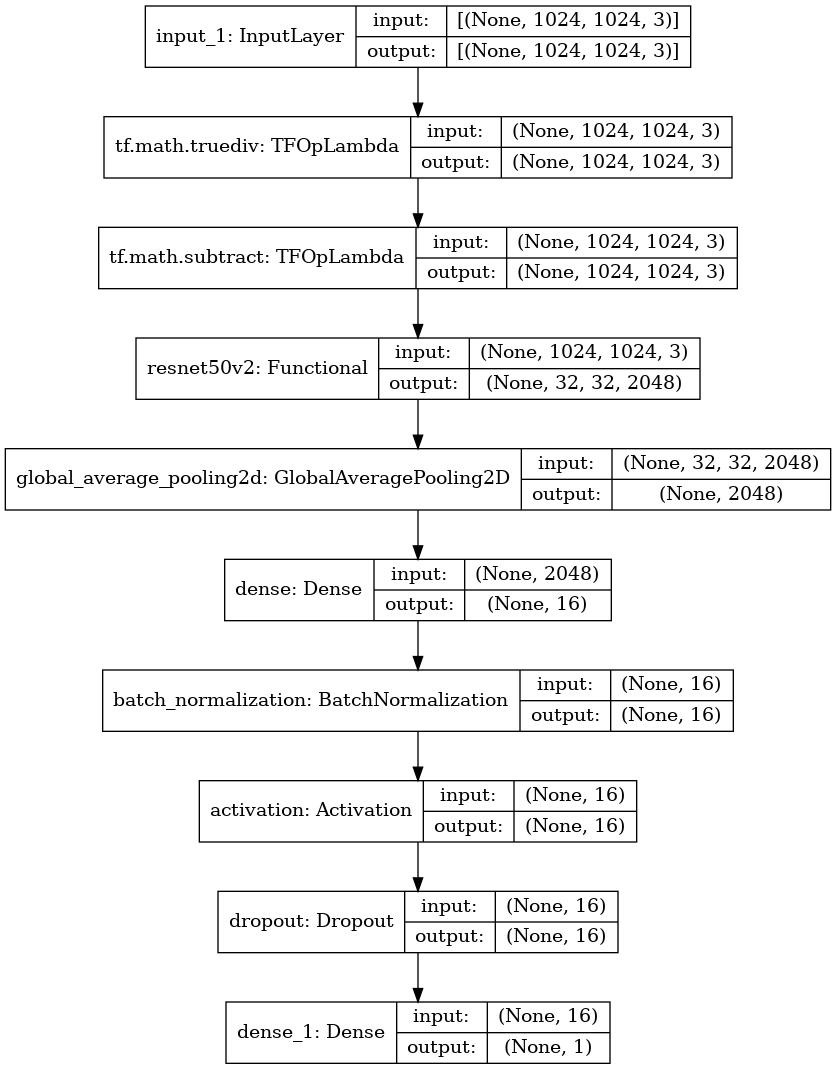

In [9]:
tf.keras.utils.plot_model(model, rankdir="UD", show_shapes=True)

In [10]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="ResNet_model_best_auc.keras",
        save_best_only=True,
        monitor="val_auc",
        mode = 'max'),
    
    
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=1,
        verbose=0,
        restore_best_weights=True,
    ),
    
    
]

### Train the model

In [11]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose = 0)

clear_output()

### Training Results

In [12]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,auc,auc_1,binary_accuracy,val_loss,val_auc,val_auc_1,val_binary_accuracy
0,0.593188,0.701625,0.539153,0.698272,0.210521,0.730128,0.169093,0.975478
1,0.388193,0.835757,0.788015,0.857765,0.163153,0.721409,0.138549,0.974106
2,0.315489,0.886178,0.856424,0.892299,0.213196,0.670457,0.113869,0.941166


In [13]:
history_df.tail()

,loss,auc,auc_1,binary_accuracy,val_loss,val_auc,val_auc_1,val_binary_accuracy
0,0.593188,0.701625,0.539153,0.698272,0.210521,0.730128,0.169093,0.975478
1,0.388193,0.835757,0.788015,0.857765,0.163153,0.721409,0.138549,0.974106
2,0.315489,0.886178,0.856424,0.892299,0.213196,0.670457,0.113869,0.941166


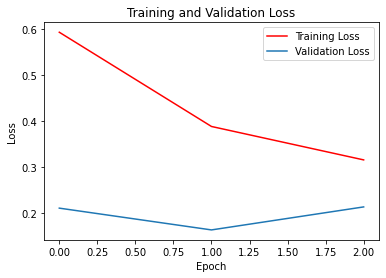

In [14]:
plt.plot(history_df.index, history_df.loss, color="red", label="Training Loss")
plt.plot(history_df.index, history_df.val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [15]:

print("Best Loss: ")
print(min(history_df.val_loss))
print('at epoch ', 1+ history_df.val_loss.idxmin())


Best Loss: 
0.16315317153930664
at epoch  2


### Grouping cases and calculating final results

In [16]:
# Get the best AUC model. This may differ from the best loss model.
model = keras.models.load_model("/kaggle/working/ResNet_model_best_auc.keras",)

In [17]:
from sklearn.metrics import roc_auc_score,precision_recall_curve, auc, fbeta_score


preds = model.predict(val_ds)
clear_output()
val_df['preds'] = preds

# We want the maximum (not average) prediction of risk in situtations involving health
grouped = val_df.groupby(["patient_id","laterality"]).max()

precision, recall, thresholds = precision_recall_curve(grouped.cancer, grouped.preds)
pr_score = auc(recall, precision)

thresh = .5
fbeta = fbeta_score((grouped.cancer>thresh).astype(int),(grouped.preds>thresh).astype(int), beta=2)# weigh recall more

In [18]:
print("Final auROC: ", roc_auc_score(grouped.cancer, grouped.preds))
print("Final auPR: ", pr_score)
print("Final fbeta: ", fbeta)

Final auROC:  0.7813942807683052
Final auPR:  0.22049217230240403
Final fbeta:  0.3093812375249501
